## MODEL 
* Install muna ako NVIDIA CUDA tas cuDNN para di sumabog PC 

In [3]:
import os
import time
import numpy as np
import io
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import load_img, img_to_array

ModuleNotFoundError: No module named 'tensorflow'

In [46]:
#Load Images
def load_images_and_labels(folder, label):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(image_path))
        images.append(image.flatten())
    labels = [label] * len(images)
    return np.array(images), np.array(labels)

In [47]:
def load_images_and_labels(folder, label):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(image_path))
        images.append(image.flatten())
    labels = [label] * len(images)
    return np.array(images), np.array(labels)

def preprocess_features(jaundiced_features_path, healthy_features_path):
    jaundiced_features_df = pd.read_csv(jaundiced_features_path).drop(columns=['Image'])
    healthy_features_df = pd.read_csv(healthy_features_path).drop(columns=['Image'])
    
    # Assuming the features are already processed and split into RGB components
    jaundiced_features = jaundiced_features_df.values
    healthy_features = healthy_features_df.values
    
    return jaundiced_features, healthy_features

train_jaundiced_features, train_healthy_features = preprocess_features(
    "./features/train_yellow_colors_results.csv", "./features/train_white_colors_results.csv"
)

print("Jaundiced features shape:", train_jaundiced_features.shape)

train_jaundiced_images, train_jaundiced_labels = load_images_and_labels("./train/train J", 1)
train_healthy_images, train_healthy_labels = load_images_and_labels("./train/train N", 0)

train_jaundiced = np.hstack((train_jaundiced_images, train_jaundiced_features))
train_healthy = np.hstack((train_healthy_images, train_healthy_features))

X_train = np.vstack((train_jaundiced, train_healthy))
y_train = np.hstack((train_jaundiced_labels, train_healthy_labels))

X_train, y_train = shuffle(X_train, y_train, random_state=1)

test_jaundiced_images, test_jaundiced_labels = load_images_and_labels("./test/test J", 1)
test_healthy_images, test_healthy_labels = load_images_and_labels("./test/test N", 0)

test_jaundiced_features, test_healthy_features = preprocess_features(
    "./features/test_yellow_colors_results.csv", "./features/test_white_colors_results.csv"
)

test_jaundiced = np.hstack((test_jaundiced_images, test_jaundiced_features))
test_healthy = np.hstack((test_healthy_images, test_healthy_features))


X_test = np.vstack((test_jaundiced, test_healthy))
y_test = np.hstack((test_jaundiced_labels, test_healthy_labels))

val_jaundiced_images, val_jaundiced_labels = load_images_and_labels("./validate/validate J", 1)
val_healthy_images, val_healthy_labels = load_images_and_labels("./validate/validate N", 0)


val_jaundiced_features, val_healthy_features = preprocess_features(
    "./features/validate_yellow_colors_results.csv", "./features/validate_white_colors_results.csv"
)


val_jaundiced = np.hstack((val_jaundiced_images, val_jaundiced_features))
val_healthy = np.hstack((val_healthy_images, val_healthy_features))

X_val = np.vstack((val_jaundiced, val_healthy))
y_val = np.hstack((val_jaundiced_labels, val_healthy_labels))


print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Jaundiced images shape:", train_jaundiced_images.shape)
print("Jaundiced features shape:", train_jaundiced_features.shape)
print("Healthy images shape:", train_healthy_images.shape)
print("Healthy features shape:", train_healthy_features.shape)
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("First 5 rows of X_train:", X_train[:5])


Jaundiced features shape: (399, 18)
Test data shape: (38, 120018)
Validation data shape: (18, 120018)
Jaundiced images shape: (399, 120000)
Jaundiced features shape: (399, 18)
Healthy images shape: (497, 120000)
Healthy features shape: (497, 18)
X_train shape: (896, 120018)
X_train dtype: float64
First 5 rows of X_train: [[177. 114.  79. ...  63.  47.  22.]
 [235. 219. 203. ... 180. 158. 138.]
 [149. 100.  70. ... 156. 108.  44.]
 [ 69.  69.  71. ... 131. 129. 128.]
 [198. 144. 120. ... 200. 174. 164.]]


In [48]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (896, 120018)
X_test shape: (38, 120018)
X_val shape: (18, 120018)


In [49]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit 
X_test = scaler.transform(X_test)       # Transform test data (images only with no annotations but with features)
X_val = scaler.transform(X_val)

In [50]:
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),  # Combined images + features
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'), #+1 Layer add more?
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary (J or N || 0 or 1)
])

c:\Users\kenji\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # loss or accuracy??
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

start_time = time.time()

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

elapsed_time = time.time() - start_time
# Evaluate 
loss, accuracy, precision = model.evaluate(X_test, y_test)
stopped = early_stopping.stopped_epoch
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Stopped at Epoch: {stopped}, {elapsed_time:.4f}")

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.5734 - loss: 0.6926 - precision_1: 0.0000e+00 - val_accuracy: 0.5556 - val_loss: 0.6922 - val_precision_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - accuracy: 0.5428 - loss: 0.6923 - precision_1: 0.0000e+00 - val_accuracy: 0.5556 - val_loss: 0.6917 - val_precision_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 421ms/step - accuracy: 0.5328 - loss: 0.6920 - precision_1: 0.0000e+00 - val_accuracy: 0.5556 - val_loss: 0.6908 - val_precision_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 419ms/step - accuracy: 0.5666 - loss: 0.6901 - precision_1: 0.0000e+00 - val_accuracy: 0.5556 - val_loss: 0.6898 - val_precision_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step - accuracy: 0.5620 - loss: 0.6893 - precision_1: 0.0000e+00 - val_accuracy: 0.5556 - val_loss: 

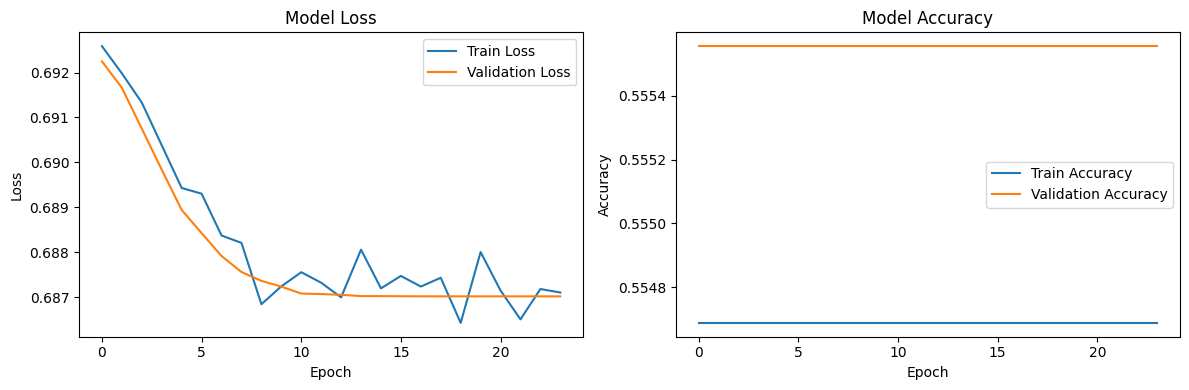

In [53]:

# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
